In [1]:
import setup
setup.init_django()
from market import services as market_services
from market import tasks as market_tasks
from market.models import Company
import json
from decouple import config

In [2]:
ticker = "GOOG"
name = "Google"
company, _ = Company.objects.get_or_create(name=name, ticker=ticker)
company.id

3

In [ ]:
market_tasks.sync_historical_stock_data(
    years_ago=1, 
    company_ids=[company.id], 
    use_celery=False, 
    verbose=True
)

# use celery / async
# market_tasks.sync_historical_stock_data.delay(years_ago=5, company_ids=[company.id], use_celery=True, verbose=False)

In [3]:
import pandas as pd
from market import services as market_services

# Assume `days` and `ticker` are already defined
days = 90
queryset = market_services.get_daily_stock_quotes_queryset(ticker, days=days)

# Extract relevant fields
historical_data_list = queryset.values(
    'time', 'open_price', 'close_price', 'high_price', 'low_price',
    'raw_timestamp', 'number_of_trades', 'volume', 'volume_weighted_average'
)

# Convert to DataFrame
historical_data = pd.DataFrame.from_records(historical_data_list)

# Convert 'time' to datetime and set as index
historical_data['time'] = pd.to_datetime(historical_data['time'])
historical_data.set_index('time', inplace=True)

# Keep only the 'close_price' column
historical_data = historical_data[['close_price']]

# Verify the structure
print(historical_data.head())


                          close_price
time                                 
2024-10-21 23:55:00+00:00    165.7500
2024-10-22 23:55:00+00:00    166.5799
2024-10-23 23:55:00+00:00    164.9100
2024-10-24 23:55:00+00:00    164.5200
2024-10-25 23:55:00+00:00    167.0000


In [4]:
print(historical_data.columns)


Index(['close_price'], dtype='object')


/home/harry/StockTradingbot/myenv/lib/python3.8/site-packages/merlion/utils/resample.py:155: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  dt = pd.to_timedelta(scipy.stats.mode(orig_t[1:] - orig_t[:-1], axis=None)[0].item())
Inferred granularity 1 days 00:00:00


<Figure size 1200x600 with 0 Axes>

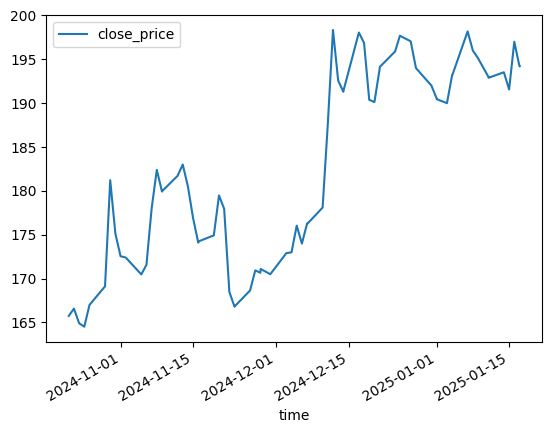

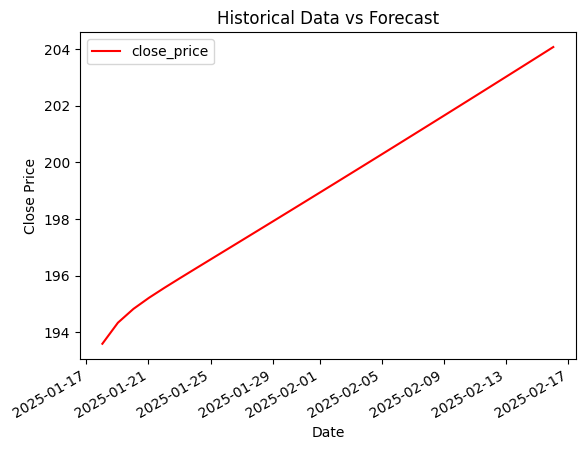

In [8]:
from merlion.models.forecast.arima import Arima, ArimaConfig
from merlion.utils.time_series import TimeSeries
import matplotlib.pyplot as plt
import pandas as pd

# Ensure the index is datetime (should already be correct from your description)
historical_data.index = pd.to_datetime(historical_data.index).tz_localize(None)  # Ensure it's tz-naive

# Convert the DataFrame to Merlion TimeSeries
time_series = TimeSeries.from_pd(historical_data)

# Define and initialize the ARMA model (ARMA is a special case of ARIMA where d=0)
arma_config = ArimaConfig(order=(2, 0, 2))  # ARMA(2, 2) as an example
model = Arima(arma_config)

# Train the ARMA model
model.train(time_series)

# Generate future timestamps for the next 30 days
future_time_stamps = pd.date_range(
    start=historical_data.index[-1] + pd.Timedelta(days=1),
    periods=30,
    freq='D'
)

# Forecast the next 30 days using future time stamps
forecast, _ = model.forecast(time_stamps=future_time_stamps)

# Convert Merlion TimeSeries to Pandas DataFrame for plotting
forecast_df = forecast.to_pd()
time_series_df = time_series.to_pd()

# Plot the original historical data and the forecasted data
plt.figure(figsize=(12, 6))
time_series_df.plot(label="Historical Data", legend=True)
forecast_df.plot(label="Forecast", legend=True, color='red')
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("Historical Data vs Forecast")
plt.show()


ModuleNotFoundError: No module named 'merlion.models.forecast.deep_forecaster'

In [11]:
from merlion.evaluate.forecast import ForecastEvaluator

evaluator = ForecastEvaluator(model=model, test_data=time_series)
score = evaluator.evaluate(metric=ForecastMetric.MAPE)
print(f"Mean Absolute Percentage Error: {score}")


TypeError: __init__() got an unexpected keyword argument 'test_data'